In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Outlines:" data-toc-modified-id="Outlines:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Outlines:</a></span></li><li><span><a href="#About-Medical-MNIST-Dataset" data-toc-modified-id="About-Medical-MNIST-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>About Medical MNIST Dataset</a></span></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span><ul class="toc-item"><li><span><a href="#Data-Info" data-toc-modified-id="Data-Info-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Info</a></span></li><li><span><a href="#Check-Sample-Image" data-toc-modified-id="Check-Sample-Image-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Check Sample Image</a></span></li></ul></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Convert-to-dataframe" data-toc-modified-id="Convert-to-dataframe-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Convert to dataframe</a></span></li><li><span><a href="#Split-to-Train,-Valid,-Test-data" data-toc-modified-id="Split-to-Train,-Valid,-Test-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Split to Train, Valid, Test data</a></span><ul class="toc-item"><li><span><a href="#Check-class-balance" data-toc-modified-id="Check-class-balance-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Check class balance</a></span></li></ul></li><li><span><a href="#Check-mean,-std,-min-and-max-from-data-training" data-toc-modified-id="Check-mean,-std,-min-and-max-from-data-training-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Check mean, std, min and max from data training</a></span></li><li><span><a href="#Create-Data-Abstraction" data-toc-modified-id="Create-Data-Abstraction-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Create Data Abstraction</a></span></li><li><span><a href="#Create-Data-Transform-Pipeline" data-toc-modified-id="Create-Data-Transform-Pipeline-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Create Data Transform Pipeline</a></span></li><li><span><a href="#Compose-all-to-DataLoader" data-toc-modified-id="Compose-all-to-DataLoader-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Compose all to DataLoader</a></span></li></ul></li><li><span><a href="#Training-Preparation" data-toc-modified-id="Training-Preparation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training Preparation</a></span><ul class="toc-item"><li><span><a href="#Create-Model-Architecture" data-toc-modified-id="Create-Model-Architecture-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create Model Architecture</a></span></li><li><span><a href="#Set-training-Model" data-toc-modified-id="Set-training-Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Set training Model</a></span></li><li><span><a href="#Set-Optimizer" data-toc-modified-id="Set-Optimizer-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Set Optimizer</a></span></li><li><span><a href="#Set-Criterion" data-toc-modified-id="Set-Criterion-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Set Criterion</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

# Outlines:
1. **About Medical MNIST Dataset**
1. **Exploratory Data Analysis (EDA)**
    1. Data Overview
    1. Data Quality Checks
    1. Correlation Matrix
1. **Feature Engineering**
    1. Choose Columns
    1. Transforming the prediction target to numerical
    1. Data Split (Train and Testing)
    1. Data Preprocessing
1. **Training CNN Model Using Pytorch Framework**
    1. Convert dataset to dataloader
    1. Create Model Blueprint
    1. Construct the Network
    1. Set Optimizer
    1. Set Criterion
    1. Training Process
    1. Plot Results
1. **Home Work Challenge**

# About Medical MNIST Dataset

This dataset is a simple MNIST-style medical images in 64x64 dimension;
There were originaly taken from other datasets and processed into such style. There are 58954 medical images belonging to 6 classes.

![Medical MNIST](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F793761%2F80e9bd2c92dbd64518c8f7be18d57b81%2FUntitled.png?generation=1587494186344589&alt=media)

Resource Dataset : [Medical-MNIST-Classification](https://github.com/apolanco3225/Medical-MNIST-Classification%7D%7D)

# Exploratory Data Analysis (EDA)

## Data Info

In [2]:
from pathlib import Path
from PIL import Image
ROOT_DATA = '/home/muchlisinadi/Documents/Projects/course/imeri/datasets/mednist'
data_path = Path(ROOT_DATA)
import random

# get Class Name
class_names = [d.name for d in data_path.iterdir()]

# get number class
num_class = len(class_names)

# get all image_file
image_files = list(data_path.rglob('*.jpeg'))

# get all image perclass
dict_file = {}
for c in class_names:
    dict_file[c] = list(data_path.rglob('{}/*.jpeg'.format(c)))

# get image width and height
image_width, image_height = Image.open(image_files[0]).size

# print all
print(f'There are {len(image_files)} images in {len(class_names)} distinct categories')
print(f'Image Dimensions : {image_width} x {image_height}')
print('Total image perclass:')
for c in class_names:
    print("Label {0:9} : {1}".format(c,len(dict_file[c])))

There are 58954 images in 6 distinct categories
Image Dimensions : 64 x 64
Total image perclass:
Label ChestCT   : 10000
Label AbdomenCT : 10000
Label HeadCT    : 10000
Label BreastMRI : 8954
Label CXR       : 10000
Label Hand      : 10000


## Check Sample Image

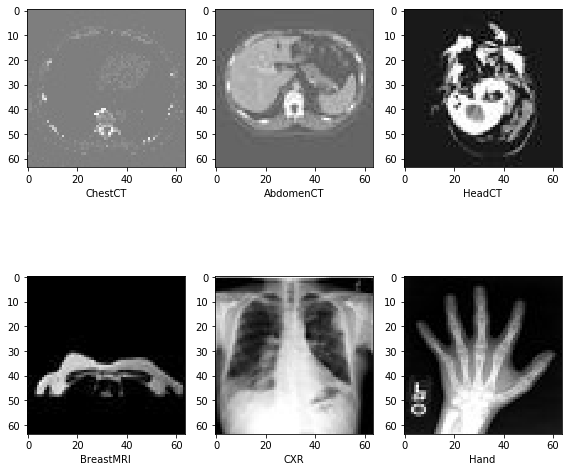

In [3]:
mp.subplots(2,3,figsize=(8,8))
for i, c in enumerate(class_names):
    im = Image.open(dict_file[c][random.randint(0, len(dict_file[c]))])
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    mp.xlabel(c)
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

# Data Preparation

## Convert to dataframe

In [4]:
import pandas as pd

# Convert data to list
list_data = []
for k, v in dict_file.items():
    for f in v:
        _dict = {'filename': f, 'class_name': k}
        list_data.append(_dict)

# To pandas dataframe
df_file_class = pd.DataFrame(list_data)

In [5]:
df_file_class.sample(5)

,filename,class_name
26775,/home/muchlisinadi/Documents/Projects/course/i...,HeadCT
53463,/home/muchlisinadi/Documents/Projects/course/i...,Hand
18441,/home/muchlisinadi/Documents/Projects/course/i...,AbdomenCT
15533,/home/muchlisinadi/Documents/Projects/course/i...,AbdomenCT
24877,/home/muchlisinadi/Documents/Projects/course/i...,HeadCT


## Split to Train, Valid, Test data
To get data train, valid and testing we can splitting using sklearn train_test_split twice

In [6]:
from sklearn.model_selection import train_test_split

# Split Dataset to train and validation
df_train, df_valid = train_test_split(df_file_class, test_size=0.4)

# Split data validation with data test
df_valid, df_test = train_test_split(df_valid, test_size=0.5) # half from before

# check data
total_data = df_file_class.shape[0]
print("Train/Valid/Test : {:0.2f}%/{:0.2f}%/{:0.2f}%".format(df_train.shape[0]/total_data, df_valid.shape[0]/total_data, df_test.shape[0]/total_data))

Train/Valid/Test : 0.60%/0.20%/0.20%


### Check class balance

In [7]:
# Data Train
df_train.groupby('class_name').size()

class_name
AbdomenCT    6012
BreastMRI    5394
CXR          5965
ChestCT      5964
Hand         6012
HeadCT       6025
dtype: int64

In [8]:
# Data Validation
df_valid.groupby('class_name').size()

class_name
AbdomenCT    1998
BreastMRI    1802
CXR          1969
ChestCT      2028
Hand         2033
HeadCT       1961
dtype: int64

In [9]:
# Data Test
df_test.groupby('class_name').size()

class_name
AbdomenCT    1990
BreastMRI    1758
CXR          2066
ChestCT      2008
Hand         1955
HeadCT       2014
dtype: int64

## Check mean, std, min and max from data training

In [32]:
from tqdm import tqdm
from torchvision import transforms

mean_list = []
std_list = []
max_list = []
min_list = []
toTensor = transforms.ToTensor()  # Convert from 0-255 to 0-1
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    _im = Image.open(row['filename'])
    _im = toTensor(_im)
    mean_list.append(_im.mean())
    std_list.append(_im.std())
    max_list.append(_im.max())
    min_list.append(_im.min())

100%|██████████| 35372/35372 [00:26<00:00, 1315.33it/s]


In [33]:
avg_mean = np.array(mean_list).mean()
avg_std = np.array(std_list).mean()
min_data = np.array(min_list).min()
max_data = np.array(max_list).max()
print(f'mean: {avg_mean}, std: {avg_std}, min: {min_data}, max: {max_data}')

mean: 0.35768333077430725, std: 0.201591357588768, min: 0.0, max: 1.0


## Create Data Abstraction

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MedicalMNIST(Dataset):
    CLASS = {'HeadCT': 0, 'BreastMRI': 1, 'AbdomenCT':2, 'CXR':3, 'ChestCT':4, 'Hand':5}
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.df.iloc[idx].filename
        labels = self.df.iloc[idx].class_name
        
        # convert to class_id
        labels = self.CLASS[labels]
        
        # load image using PIL
        image = Image.open(file_name)
        
        # if any transform
        if self.transform:
            image = self.transform(image)
            
        return image, labels

## Create Data Transform Pipeline

In [13]:
# List transform pipeline
_transform = []
_transform.append(transforms.ToTensor()) # Convert (from 0-255 to 0-1) and tensor datatype
_transform.append(transforms.Normalize(mean=(0.3577,), std=(0.2016,))) # normalize each data with predefine mean and std

# compose all to one function
transform = transforms.Compose(_transform)

## Compose all to DataLoader
Sometimes one epoch is too big to feed to the computer at once we divide it in several smaller batches. <br>
`Epoch` = **One Epoch** is when an **ENTIRE dataset** is passed **forward** and **backward** through the neural network **only ONCE**. <br>
`Batch Size` = Total number of training examples present **in a single batch**.

In [14]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Parameter batch_size
train_batchsize = 100
valid_batchsize = 100
test_batchsize = 100

# Construct pipeline
train_dataset = MedicalMNIST(df_train, transform)
valid_dataset = MedicalMNIST(df_valid, transform)
test_dataset = MedicalMNIST(df_test, transform)

# Create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=train_batchsize)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=test_batchsize)

In [15]:
# get sample data
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

In [16]:
batch_idx

0

In [17]:
example_data.shape

torch.Size([100, 1, 64, 64])

In [18]:
example_targets.shape

torch.Size([100])

# Training Preparation

## Create Model Architecture 

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [20]:
class Net(nn.Module):
    def __init__(self, output_class=6):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20*16*16, 50)
        self.fc2 = nn.Linear(50, output_class)

    def forward(self, x):
        # first
        x = self.conv1(x) # batch_size x 16 x 64 x 64
        x = F.max_pool2d(x, 2) # batch_size x 16 x 32 x 32
        x = F.relu(x)
        
        # second
        x = self.conv2(x) # batch_size x 20 x 32 x 32
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2) # batch_size x 20 x 16 x 16
        x = F.relu(x)
        
        # linear
        x = x.view(-1, 20*16*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Set training Model

In [21]:
network = Net()

# with Cuda Gpu Acceleration
if torch.cuda.is_available():
    network.cuda()

## Set Optimizer
- [Simple theory of Optimizers](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3)
- [Torch optim doc](https://pytorch.org/docs/stable/optim.html)

In [22]:
learning_rate = 0.001
momentum = 0.2
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Set Criterion
- [a brief overview of loss function in pytorch](https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7)

In [23]:
criterion = nn.NLLLoss() #  nn.MSELoss() # nn.SmoothL1Loss() # nn.NLLLoss()

# Training

In [24]:
from tqdm import tqdm

def get_accuracy(y_pred, y_test):
    pred = y_pred.data.max(1, keepdim=True)[1]
    total_true = pred.eq(y_test.data.view_as(pred)).sum().item()
    return total_true/len(y_test)

def one_epoch_train(idx_epoch, network, optimizer, data_loader):
    """
    One Epoch Training Function
    """
    # init arrays
    acc_epoch = np.zeros(len(data_loader))
    loss_epoch = np.zeros(len(data_loader))
    
    # Set to Train mode on
    network.train() 
    # Start Training
    pbar = tqdm(data_loader, desc=f"train epoch {idx_epoch}")
    for batch_idx, (data, target) in enumerate(pbar):
        
        # Convert data and target to cuda datatype
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # Main Training Process
        optimizer.zero_grad() # Clear all Gradient in Optimizer
        output = network(data) # Forward Propagation
        loss = criterion(output, target) # Calculcate loss between forward result and target
        loss.backward() # Backward Propagation
        optimizer.step() # Update Gradient in Optimizer
        
        # Put loss and accuracy to arrays
        loss_epoch[batch_idx] = loss.item()
        acc_epoch[batch_idx] = get_accuracy(output, target)
        
        # Add loss and acc in progress bar
        pbar.set_postfix(loss='{:0.4f}'.format(loss.item()), acc='{:0.4f}'.format(acc_epoch[batch_idx]))
        
    return loss_epoch, acc_epoch

def one_epoch_test(idx_epoch, network, optimizer, data_loader):
    """
    One Epoch Testing Function
    """
    # init arrays
    acc_epoch = np.zeros(len(data_loader))
    loss_epoch = np.zeros(len(data_loader))
    
    # Set to Train mode of
    network.eval()
    
    pbar = tqdm(data_loader, desc=f"eval epoch {idx_epoch}")
    
    # Should deactivate all gradient proccess
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):

            # Convert data and target to cuda datatype
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()

            # Main Training Process
            output = network(data) # Only Forward Propagation
            loss = criterion(output, target) # Calculcate loss between forward result and target

            # Put loss and accuracy to arrays
            loss_epoch[batch_idx] = loss.item()
            acc_epoch[batch_idx] = get_accuracy(output, target)
            
            # Add loss and acc in progress bar
            pbar.set_postfix(loss='{:0.4f}'.format(loss.item()), acc='{:0.4f}'.format(acc_epoch[batch_idx]))
        
    return loss_epoch.mean(), acc_epoch.sum()/len(data_loader)

In [25]:
n_epochs = 3
log_interval = 1

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for idx_epoch in range(1, n_epochs+1):
    train_loss, train_acc = one_epoch_train(idx_epoch ,network, optimizer, train_dataloader)
    test_loss, test_acc = one_epoch_test(idx_epoch, network, optimizer, valid_dataloader)
    
    train_losses += list(train_loss)
    train_accs += list(train_acc)
    test_losses += [None]*(len(train_loss)-1) + [test_loss]
    test_accs += [None]*(len(train_acc)-1) + [test_acc]
    
    if idx_epoch % log_interval == 0:
        print('Train Epoch: {}/{} \t loss(train | valid): {:.6f} | {:.6f} \t acc(train|valid): {:.4f}% | {:.4f}%'.format(idx_epoch, n_epochs, train_loss.mean(), test_loss, train_acc.mean(), test_acc))

train epoch 2:   0%|          | 1/354 [00:00<00:55,  6.31it/s, acc=0.6000, loss=1.1847]

Train Epoch: 1/3 	 loss(train | valid): 1.521720 | 0.980267 	 acc(train|valid): 0.4582% | 0.7856%


train epoch 3:   0%|          | 1/354 [00:00<00:55,  6.41it/s, acc=0.8500, loss=0.5798]

Train Epoch: 2/3 	 loss(train | valid): 0.807082 | 0.362719 	 acc(train|valid): 0.7582% | 0.9394%


eval epoch 3: 100%|██████████| 118/118 [00:16<00:00,  7.17it/s, acc=0.9890, loss=0.1654]

Train Epoch: 3/3 	 loss(train | valid): 0.458990 | 0.198605 	 acc(train|valid): 0.8766% | 0.9631%


In [26]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

def plot_(train, test=None, xlabel="epoch", ylabel="loss", title="Result Training", rolling=20):
    """
    Function for plot the result
    """
    df = pd.DataFrame()
    df['train'] = train
    df = df.rolling(rolling).mean()
    sns.lineplot(hue="region", style="event",data=df[['train']])
    if test:
        df['test'] = test
        sns.scatterplot(data=df[['test']], palette="flag_r")

    # other info
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

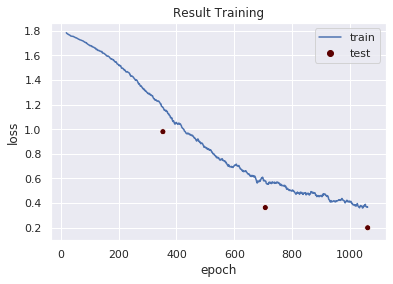

In [27]:
# Check Loss
plot_(train_losses, test_losses)

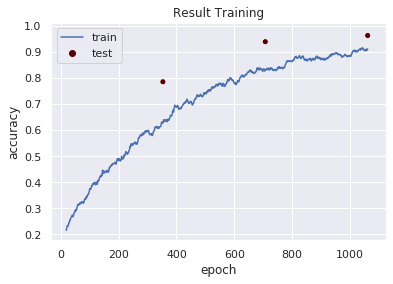

In [28]:
# Check accuracy
plot_(train_accs, test_accs, ylabel="accuracy")

In [29]:
def predict(file, to_name=True):
    
    CLASS = {0:'HeadCT', 1:'BreastMRI', 2:'AbdomenCT', 3:'CXR', 4:'ChestCT', 5:'Hand'}
    
    im = Image.open(file)
    im = transform(im).view(1,1,64,64)
    
    if torch.cuda.is_available():
        network.cuda()
        im = im.cuda()
        
    network.eval()
    with torch.no_grad():
        y_pred = network(im)
        pred = y_pred.data.max(1, keepdim=True)[1]
        
    return CLASS[pred.item()] if to_name else pred.item()

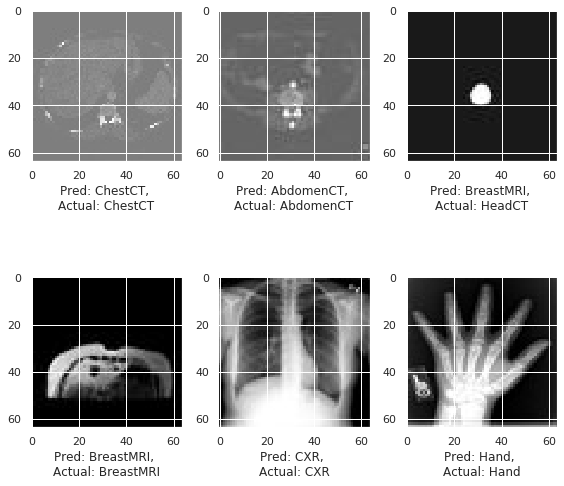

In [31]:
mp.subplots(2,3,figsize=(8,8))
for i, c in enumerate(class_names):
    filename = df_test[df_test['class_name'] == c].sample().filename.values[0]
    pred = predict(filename)
    im = Image.open(filename)
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    mp.xlabel(f"Pred: {pred}, \nActual: {c}")
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()